## Парсинг Лента, Риа, Фонтанка

In [1]:
# Импорт библиотек
import requests as rq
#from bs4 import BeautifulSoup as bs
import pandas as pd
import numpy as np
import pickle
#from google.colab import files
from tqdm import tqdm as tqdm_bar
from datetime import datetime, timedelta
from IPython import display
import requests as rq
from bs4 import BeautifulSoup as bs
import pandas as pd
import numpy as np
import pickle
from selenium import webdriver
import time
import tqdm
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
import spacy
from sentence_transformers import SentenceTransformer
from joblib import Parallel, delayed
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from spacy.lang.ru.stop_words import STOP_WORDS
from transformers import BertTokenizer, BertModel
import torch
from torch.multiprocessing import Pool
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.preprocessing import MaxAbsScaler,StandardScaler
from pymorphy2 import MorphAnalyzer
from concurrent.futures import ProcessPoolExecutor
from tqdm import tqdm
nlp = spacy.load("ru_core_news_sm")
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import warnings
warnings.filterwarnings("ignore")

### Лента.ру

* __query__ - поисковой запрос (ключевое слово)

* __offset__ - cмещение поисковой выдачи (от 0 до __size__)

* __size__ - количество статей. Ограничено время запроса, точного лимита нет. 1000 работает почти всегда

* __sort__ - сортировка по дате: (2) - по убыванию, (3) - по возрастанию; по релевантности (1)

* __title_only__ - точная фраза в заголовке (1)

* __domain__ - ?

* __material__ - материалы: Все материалы (0). Новость (1). ["0", "1", "2", "3", "4", ...]

* __block__ - рубрика: Экономика (4). Все рубрики (0). ["0", "1", "2", "3", "4", ...]

* __dateFrom__ - с даты

* __dateTo__ - по дату



In [6]:

def _get_url(param_dict: dict) -> str:
    """
    Возвращает URL для запроса json таблицы со статьями

    """
    hasType = int(param_dict['type']) != 0
    hasBloc = int(param_dict['bloc']) != 0

    url = 'https://lenta.ru/search/v2/process?'\
    + 'from={}&'.format(param_dict['from'])\
    + 'size={}&'.format(param_dict['size'])\
    + 'sort={}&'.format(param_dict['sort'])\
    + 'title_only={}&'.format(param_dict['title_only'])\
    + 'modified%2Cformat=yyyy-MM-dd&'\
    + 'type={}&'.format(param_dict['type']) * hasType\
    + 'bloc={}&'.format(param_dict['bloc']) * hasBloc\
    + 'modified%2Cfrom={}&'.format(param_dict['dateFrom'])\
    + 'modified%2Cto={}&'.format(param_dict['dateTo'])

    return url


def _get_search_table(param_dict: dict) -> pd.DataFrame:
    """
    Возвращает pd.DataFrame со списком статей
    """
    url = _get_url(param_dict)
    r = rq.get(url)
    search_table = pd.DataFrame(r.json()['matches'])

    return search_table


def get_articles( param_dict,
                  time_step = 1,
                  save_every = 5,
                  save_excel = True) -> pd.DataFrame:
    """
    Функция для скачивания статей интервалами через каждые time_step дней
    Делает сохранение таблицы через каждые save_every * time_step дней

    """
    param_copy = param_dict.copy()
    time_step = timedelta(days=time_step)
    dateFrom = datetime.strptime(param_copy['dateFrom'], '%Y-%m-%d')
    dateTo = datetime.strptime(param_copy['dateTo'], '%Y-%m-%d')
    if dateFrom > dateTo:
        raise ValueError('dateFrom should be less than dateTo')

    out = pd.DataFrame()
    save_counter = 0

    for _ in tqdm_bar(range((dateTo - dateFrom).days + 1), desc="Processing dates"):
        param_copy['dateTo'] = (dateFrom + time_step).strftime('%Y-%m-%d')
        if dateFrom + time_step > dateTo:
            param_copy['dateTo'] = dateTo.strftime('%Y-%m-%d')
        print('Parsing articles from ' + param_copy['dateFrom'] + ' to ' + param_copy['dateTo'])
        out = out.append(_get_search_table(param_copy), ignore_index=True)
        dateFrom += time_step + timedelta(days=1)
        param_copy['dateFrom'] = dateFrom.strftime('%Y-%m-%d')
        save_counter += 1
        display.clear_output(wait=True)
        if save_counter == save_every:
            display.clear_output(wait=True)
            #out.to_excel("/tmp/checkpoint_table.xlsx")
            print('Checkpoint saved!')
            save_counter = 0

    if save_excel:
        out.to_excel("lenta_{}_{}.xlsx".format(
            param_dict['dateFrom'],
            param_dict['dateTo']))
    print('Finish')

    return out

In [9]:
offset = 0
size = 1000
sort = "3"
title_only = "0"

material = "0"
bloc = "0"
dateFrom = '2021-08-01'
dateTo = "2023-12-31"

param_dict = {
              'from'      : str(offset),
              'size'      : str(size),
              'dateFrom'  : dateFrom,
              'dateTo'    : dateTo,
              'sort'      : sort,
              'title_only': title_only,
              'type'      : material,
              'bloc'      : bloc,                  }


In [10]:
lenta_data = get_articles(param_dict=param_dict,
                         time_step = 1,
                         save_every = 10000,
                         save_excel = False)
print(len(lenta_data))

Processing dates: 100%|██████████| 883/883 [25:48<00:00,  1.75s/it]

Finish

385331


In [11]:
lenta_data = lenta_data[['url','title', 'text', 'bloc']]
lenta_data

,url,title,text,bloc
0,https://lenta.ru/news/2021/08/01/teplo/,Москвичам пообещали возвращение тепла,Фото: Гришкин Денис / Агентство «Москва» Ксени...,1
1,https://lenta.ru/news/2021/08/01/finn/,Финского полицейского уличили в сборе средств ...,Фото: Heikki Saukkomaa / Reuters Марина Совина...,2
2,https://lenta.ru/news/2021/07/31/stelba/,Звезда TikTok умер от полученных при стрельбе ...,Фото: Mike Blake / Reuters Марина Совина Звезд...,7
3,https://lenta.ru/news/2021/08/01/poor_animals/,В России разрешили добычу краснокнижных животных,Фото: Unsplash Ксения Назарова В России разреш...,1
4,https://lenta.ru/news/2021/08/01/udalenie/,Эксперт раскрыл способ безвозвратно удалить да...,Фото: Annette Riedl / dpa / Global Look Press ...,5
...,...,...,...,...
385326,https://lenta.ru/news/2024/01/01/v-novogodnem-...,В новогоднем эфире Первого канала выступил укр...,Аким Апачев Фото: Екатерина Чеснокова / РИА Но...,7
385327,https://lenta.ru/news/2024/01/01/chislo-pogibs...,Число погибших и раненых в результате новогодн...,Фото: Konstantin Kokoshkin / Global Look Press...,3
385328,https://lenta.ru/news/2024/01/01/v-rade-zayavi...,В Раде заявили о сильном воздействии «Слова па...,Фото: Stringer / Reuters Александра Синицына О...,3
385329,https://moslenta.ru/news/lyudi/rak-zheludka-01...,Онколог дал советы по своевременному обнаружен...,None,0


In [12]:
lenta_data['bloc'].unique()

array([ 1,  2,  7,  5,  8,  9,  0,  4, 48,  3, 37, 12,  6, 47, 86, 49, 11,
       35, 40, 53, 87])

Темы оригинальные:
- Мослента  и мотор 0
- Россия -1    +
- Мир 2
- бывший ссср 3 +
- экономика 4 +
- наука и техника 5 +
- культура 6
- интернет и сми 7
- спорт 8 +
- из жизни 9
- extlink 11
- среда обитания 12
- силовые структуры 37 +
- путешествия 48 +
- ценности 47
- 69 параллель 49
- бизнес 40
- нацпроекты 53
- оружие 35
- моя страна 86
- забота о себе 87 +

Темы задачи:
- 'Общество/Россия' : 0
- 'Экономика' : 1
- 'Силовые структуры' : 2
- 'Бывший СССР' : 3
- 'Спорт' : 4
- 'Забота о себе' : 5
- 'Строительство' : 6
- 'Туризм/Путешествия' : 7
- 'Наука и техника' : 8

In [13]:
lenta_data = lenta_data[lenta_data['bloc'].isin([1, 3, 4, 5, 8, 37, 48, 87])]# Отфильтруем нужные темы

lenta_data['category'] = lenta_data['bloc'].replace({1: 0, 4: 1, 37: 2, 8: 4, 87: 5, 48: 7, 5: 8}) # Заменим оригинальные коды на нужные
lenta_data = lenta_data.drop('bloc', axis = 1)

In [14]:
lenta_data

,url,title,text,category
0,https://lenta.ru/news/2021/08/01/teplo/,Москвичам пообещали возвращение тепла,Фото: Гришкин Денис / Агентство «Москва» Ксени...,0
3,https://lenta.ru/news/2021/08/01/poor_animals/,В России разрешили добычу краснокнижных животных,Фото: Unsplash Ксения Назарова В России разреш...,0
4,https://lenta.ru/news/2021/08/01/udalenie/,Эксперт раскрыл способ безвозвратно удалить да...,Фото: Annette Riedl / dpa / Global Look Press ...,8
5,https://lenta.ru/news/2021/08/01/fakt/,Изобретатель антисептика заявил о возможном су...,Фото: Nguyen Huy Kham / Reuters Марина Совина ...,8
6,https://lenta.ru/news/2021/08/01/derevo/,Россиянка украла 40-килограммовое дерево и поп...,Фото: группа «Музей компьютеров и игр Екатерин...,0
...,...,...,...,...
385324,https://lenta.ru/news/2024/01/01/na-ukraine-vy...,На Украине высказались о возможной смене власти,Фото: Thomas Peter / Reuters Марина Совина Дир...,3
385325,https://lenta.ru/news/2024/01/01/pushilin-soob...,Пушилин сообщил о трех погибших в результате о...,Денис Пушилин Фото: Сергей Пивоваров / РИА Нов...,3
385327,https://lenta.ru/news/2024/01/01/chislo-pogibs...,Число погибших и раненых в результате новогодн...,Фото: Konstantin Kokoshkin / Global Look Press...,3
385328,https://lenta.ru/news/2024/01/01/v-rade-zayavi...,В Раде заявили о сильном воздействии «Слова па...,Фото: Stringer / Reuters Александра Синицына О...,3


In [ ]:
"""with open('lenta_data.pkl', 'wb') as file:
    pickle.dump(lenta_data, file)

files.download('lenta_data.pkl')"""

## FONTANKA.RU

In [ ]:
def get_fontanka_urls(year):
    base_url = f'https://www.fontanka.ru/stroy/arc/{year}/news.html' # Собираю записи из архива за год

    response = rq.get(base_url)
    soup = bs(response.text, 'html.parser')

    links = soup.find_all('a',  {"class": "H9ad5"})# Находим все ссылки на новости в календаре
    urls =[f'https://www.fontanka.ru{link.get("href")}' for link in links]# Извлекаем URL из атрибута href

    return urls

In [ ]:
fontanka_urls_2019 = get_fontanka_urls(2019)
fontanka_urls_2020 = get_fontanka_urls(2020)
fontanka_urls_2021 = get_fontanka_urls(2021)
fontanka_urls_2022 = get_fontanka_urls(2022)
fontanka_urls_2023 = get_fontanka_urls(2023)

fontanka_stroy = fontanka_urls_2019 + fontanka_urls_2020 + fontanka_urls_2021 + fontanka_urls_2022 + fontanka_urls_2023# Все записи из архива за 5 лет
len(fontanka_stroy)

1268

In [ ]:
fontanka_stroy_data = []
for i in fontanka_stroy:
  try:
    try:
      rs = rq.get(i)
      soup = bs(rs.text, 'html.parser')

      article = soup.find('a',  {"class": "IXdb"})
      if 'http' in str(article):
        url = f'{article.get("href")}'
        fontanka_stroy_data.append(url)
      else:
        url = f'https://www.fontanka.ru{article.get("href")}' # Получаем ссылки на конкретные страницы с новостями
        fontanka_stroy_data.append(url)

    except:
        rs = rq.get(i)
        soup = bs(rs.text, 'html.parser')
        a_tag = soup.find('div', {"class": "IXagh"}).find('a')
        if 'http' in str(article):
          url = f'{a_tag.get("href")}'
          fontanka_stroy_data.append(url)
        else:
          url = f'https://www.fontanka.ru{a_tag.get("href")}'
          fontanka_stroy_data.append(url)

  except:
    fontanka_stroy_data.append(url)
    continue

In [ ]:
df_fontanka_stroy = pd.DataFrame(columns=['url', 'title', 'text', 'category'])

for url in tqdm_bar(fontanka_stroy_data, desc="Processing URLs"):
    response = rq.get(url)
    soup = bs(response.text, 'html.parser')

    try:
        title = soup.find('h1', class_='BLbt primaryH4HeadlineMobile primaryH2HeadlineTablet').text # Извлекаем текст из страниц
        text_elements = soup.find_all('div', class_='KThj')
        article_text = '\n'.join(element.text for element in text_elements)
    except:
        continue

    df_fontanka_stroy = df_fontanka_stroy.append({
        'url': url,
        'title': title,
        'text': article_text,
        'category': 6    }, ignore_index=True)

print(df_fontanka_stroy.shape)
df_fontanka_stroy.sample(5)

Processing URLs: 100%|██████████| 1268/1268 [24:50<00:00,  1.18s/it]

(1108, 4)


,url,title,text,category
840,https://www.fontanka.ru/2023/01/19/71988014/,«Образцовому кварталу 11» присвоен «красивый» ...,Очередной жилой квартал на Царскосельских холм...,6
959,https://www.fontanka.ru/2023/06/20/72415727/?e...,На Царскосельских холмах началась передача ква...,Жилой комплекс возвёл специализированный застр...,6
718,https://www.fontanka.ru/2022/08/05/71547251/,"«ПСК Эксперт»: о новом генплане Петербурга, до...",Новый выпуск подкаста «ПСК Эксперт» поднимает ...,6
267,https://www.fontanka.ru/2020/09/02/69453079/,29 октября — круглый стол «Новые районы. Куда ...,Городской портал «Фонтанка.ру» проводит онлайн...,6
1103,https://www.fontanka.ru/2023/12/25/73057070/?e...,Предновогодние цены в «Морской набережной»,Только в декабре застройщик ЛСР предлагает при...,6


In [ ]:
with open('df_fontanka_stroy.pkl', 'wb') as file:
    pickle.dump(df_fontanka_stroy, file)

files.download('df_fontanka_stroy.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# RIA

In [ ]:

options = webdriver.ChromeOptions()
options.add_argument('--headless')
options.add_argument('--no-sandbox')
options.add_argument('--disable-dev-shm-usage')

In [ ]:
def get_links_from_ria(url, depth):
    driver = webdriver.Chrome(options=options)
    driver.get(url)

    urls = []

    try:
        driver.execute_script("document.getElementsByClassName('list-more')[0].click()") # Находит кнопку загрузить еще и далее скроллит
        time.sleep(2)

        for i in tqdm_bar(range(depth), leave=False):
            try:
                driver.execute_script("window.scrollTo(0, document.body.scrollHeight - 1200)")
                time.sleep(1)
            except:
                continue

        page_source = driver.page_source
        soup = bs(page_source, 'html.parser')
        links = soup.find_all('a', {"class": "list-item__title color-font-hover-only"})
        urls.extend(link.get("href") for link in links)

    except Exception as e:
        print(f"An error occurred: {e}")

    finally:
        driver.quit()
        return urls

In [ ]:
ria_stroy_link = get_links_from_ria('https://realty.ria.ru/tag_thematic_category_Stroitelstvo/', 300) # Получим ссылки со страницы с тегом строительство
len(set(ria_stroy_link))

5160

In [ ]:
ria_society_link = get_links_from_ria('https://realty.ria.ru/society/', 300) # Получим ссылки со страницы с тегом общество
len(set(ria_society_link))

3600

In [ ]:
ria_science_link = get_links_from_ria('https://realty.ria.ru/science/', 300) # Получим ссылки со страницы с тегом наука
len(set(ria_science_link))

5140

In [ ]:
ria_economy_link = get_links_from_ria('https://ria.ru/economy/', 300) # Получим ссылки со страницы с тегом экономика
len(set(ria_economy_link))

3552

In [ ]:
df_ria_stroitelstvo = pd.DataFrame(columns=['url', 'title', 'text', 'category'])
unread = []
for url in tqdm_bar(ria_stroy_link, leave=False):# Проходим по каждой ссылке и парсим содержимое
    response = rq.get(url)
    soup = bs(response.text, 'html.parser')
    try:
      try:
        title = 0 #soup.find('div', class_='article__title').text          # Структура у риа и радиоспутник разная
        text_elements = soup.find_all('div', class_='article__text')
        article_text = '\n'.join(element.text for element in text_elements)
      except:
        title = 0#soup.find('h1', class_='article__title').text
        text_elements = soup.find_all('div', class_='article__text')
        article_text = '\n'.join(element.text for element in text_elements)
    except:
      unread.append(url)   # Тут будут лонгриды
      continue
    df_ria_stroitelstvo = df_ria_stroitelstvo.append({'url': url, 'title': title, 'text': article_text, 'category': 6}, ignore_index=True) # Добавляем данные в DataFrame
print(df_ria_stroitelstvo.shape)
df_ria_stroitelstvo.sample(5)

In [ ]:
df_ria_society = pd.DataFrame(columns=['url', 'title', 'text', 'category'])
unread_s = []
for url in tqdm_bar(ria_society_link, leave=False):# Проходим по каждой ссылке и парсим содержимое
    response = rq.get(url)
    soup = bs(response.text, 'html.parser')
    try:
      try:
        #title = soup.find('div', class_='article__title').text          # Структура у риа и радиоспутник разная
        text_elements = soup.find_all('div', class_='article__text')
        article_text = '\n'.join(element.text for element in text_elements)
      except:
        #title = soup.find('h1', class_='article__title').text
        text_elements = soup.find_all('div', class_='article__text')
        article_text = '\n'.join(element.text for element in text_elements)
    except:
      unread_s.append(url)
      continue
    df_ria_society = df_ria_society.append({'url': url, 'title': title, 'text': article_text, 'category': 0}, ignore_index=True) # Добавляем данные в DataFrame
print(df_ria_society.shape)
df_ria_society.sample(5)

In [ ]:
df_ria_science = pd.DataFrame(columns=['url', 'title', 'text', 'category'])
unread = []
for url in tqdm_bar(ria_science_link, leave=False):# Проходим по каждой ссылке и парсим содержимое
    response = rq.get(url)
    soup = bs(response.text, 'html.parser')
    try:
      try:
        #title = soup.find('div', class_='article__title').text          # Структура у риа и радиоспутник разная
        text_elements = soup.find_all('div', class_='article__text')
        article_text = '\n'.join(element.text for element in text_elements)
      except:
        #title = soup.find('h1', class_='article__title').text
        text_elements = soup.find_all('div', class_='article__text')
        article_text = '\n'.join(element.text for element in text_elements)
    except:
      unread.append(url)
      continue
    df_ria_science = df_ria_science.append({'url': url, 'title': title, 'text': article_text, 'category': 8}, ignore_index=True) # Добавляем данные в DataFrame
print(df_ria_science.shape)
df_ria_science.sample(5)

In [ ]:
df_ria_economy = pd.DataFrame(columns=['url', 'title', 'text', 'category'])
unread = []
for url in tqdm_bar(ria_economy_link, leave=False):# Проходим по каждой ссылке и парсим содержимое
    response = rq.get(url)
    soup = bs(response.text, 'html.parser')
    try:
      try:
        #title = soup.find('div', class_='article__title').text          # Структура у риа и радиоспутник разная
        text_elements = soup.find_all('div', class_='article__text')
        article_text = '\n'.join(element.text for element in text_elements)
      except:
        #title = soup.find('h1', class_='article__title').text
        text_elements = soup.find_all('div', class_='article__text')
        article_text = '\n'.join(element.text for element in text_elements)
    except:
      unread.append(url)
      continue
    df_ria_economy = df_ria_economy.append({'url': url, 'title': title, 'text': article_text, 'category': 1}, ignore_index=True) # Добавляем данные в DataFrame
print(df_ria_economy.shape)
df_ria_economy.sample(5)

In [ ]:
with open('df_ria_society.pkl', 'wb') as file:
    pickle.dump(df_ria_society, file)

files.download('df_ria_society.pkl')

with open('df_ria_stroitelstvo.pkl', 'wb') as file:
    pickle.dump(df_ria_stroitelstvo, file)

files.download('df_ria_stroitelstvo.pkl')


with open('df_ria_science.pkl', 'wb') as file:
    pickle.dump(df_ria_science, file)

files.download('df_ria_science.pkl')

with open('df_ria_economy.pkl', 'wb') as file:
    pickle.dump(df_ria_economy, file)

files.download('df_ria_economy.pkl')

# Подготовка датасета

In [69]:
"""with open('/content/lenta_data.pkl', 'rb') as file:
    df_lenta = pickle.load(file)"""

with open('/content/df_fontanka_stroy.pkl', 'rb') as file:
    df_fontanka_stroy = pickle.load(file)

"""with open('/content/df_ria_economy.pkl', 'rb') as file:
    df_ria_economy = pickle.load(file)"""

"""with open('/content/df_ria_science.pkl', 'rb') as file:
    df_ria_science = pickle.load(file)"""

with open('/content/df_ria_society.pkl', 'rb') as file:
    df_ria_society = pickle.load(file)

with open('/content/df_ria_stroitelstvo.pkl', 'rb') as file:
    df_ria_stroy = pickle.load(file)

In [20]:
df =[]
df = pd.concat([lenta_data,  df_fontanka_stroy, df_ria_stroy], ignore_index=True)
df =  df.drop_duplicates()
df = df.dropna()

In [ ]:
"""with open('data.pkl', 'wb') as file:
    pickle.dump(df, file)

files.download('data.pkl')"""

In [27]:
"""df = pd.read_pickle('/kaggle/input/final-news-dataset/data.pkl')
df"""

,url,title,text,category
0,https://lenta.ru/news/2021/08/01/teplo/,Москвичам пообещали возвращение тепла,Фото: Гришкин Денис / Агентство «Москва» Ксени...,0
1,https://lenta.ru/news/2021/08/01/poor_animals/,В России разрешили добычу краснокнижных животных,Фото: Unsplash Ксения Назарова В России разреш...,0
2,https://lenta.ru/news/2021/08/01/udalenie/,Эксперт раскрыл способ безвозвратно удалить да...,Фото: Annette Riedl / dpa / Global Look Press ...,8
4,https://lenta.ru/news/2021/08/01/derevo/,Россиянка украла 40-килограммовое дерево и поп...,Фото: группа «Музей компьютеров и игр Екатерин...,0
5,https://lenta.ru/news/2021/08/01/iss_and_nasa/,В НАСА допустили эксплуатацию МКС после 2028 года,Фото: Oleg Novitskiy / Roscosmos / Reuters Ксе...,8
...,...,...,...,...
175061,https://realty.ria.ru/20200313/1568552524.html,Мишустин поручил выделить 200 млн рублей на ре...,"КОСТРОМА, 13 мар - РИА Новости. Премьер-минист...",0
175062,https://realty.ria.ru/20200313/1568551280.html,Фонд защиты дольщиков Башкортостана достроит п...,"МОСКВА, 13 мар - РИА Недвижимость. Фонд защиты...",0
175063,https://realty.ria.ru/20200313/1568548844.html,Московские энергетики перешли в режим повышенн...,"МОСКВА, 13 мар - РИА Недвижимость. Сотрудники ...",0
175064,https://realty.ria.ru/20200313/1568547619.html,Эксперты зафиксировали рост спроса и предложен...,"МОСКВА, 13 мар - РИА Недвижимость. В крупных р...",0


In [90]:
df.drop(df[df['category'] ==7].sample(500).index, inplace=True)
#df.drop(df[df['category'] ==2].sample(200).index, inplace=True) Балансирую распределение как в тесте

In [11]:
df['category'].value_counts(normalize=True)

category
0    0.420926
3    0.128057
1    0.119592
4    0.094287
2    0.071335
8    0.063500
7    0.053552
6    0.028067
5    0.020682
Name: proportion, dtype: float64

In [ ]:
"""
0 43.4
1 11.95
2 7.06
3 12.45 Распределение в тесте
4 9.65
5 1.37
6 2.78
7 5.12
8 6.24
""""

In [28]:
X = df['text'] #
y = df['category']
y = y.astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=43, shuffle = True)
y_train = y_train.astype(int)
y_test = y_test.astype(int)

In [5]:
X_train

15378     Фото: Артем Краснов / Коммерсантъ Варвара Коше...
39746     Фото: Александр Миридонов / Коммерсантъ Анна Щ...
14335     Фото: Валерий Мельников / РИА Новости Марина С...
47513     Фото: Vasily Fedosenko / Reuters Марина Совина...
168056    Дефицит мест в образовательных учреждениях зас...
                                ...                        
135984    Фото: Владимир Песня / РИА Новости Варвара Кош...
131893    Фото: Александр Манзюк / Коммерсантъ Влада Гор...
43129     Фото: Артем Геодакян / ТАСС Анна Щербакова Цен...
158919    Фото: Viacheslav Ratynskyi / Reuters Никита Аб...
15043     Фото: Pixabay Марина Совина Менеджер по развит...
Name: text, Length: 133252, dtype: object

# raw + bow + scaler + lr 88.66

In [107]:
vec = CountVectorizer()
vec.fit(X_train)

bow = vec.transform(X_train)  
bow_test = vec.transform(X_test)

print(bow.shape)

scaler = MaxAbsScaler()
bow = scaler.fit_transform(bow)
bow_test = scaler.transform(bow_test)

clf = LogisticRegression(max_iter=2000, random_state=43, penalty='l2') # Лучший результат
clf.fit(bow, y_train)
pred = clf.predict(bow_test)

print(classification_report(y_test, pred))

(133252, 406040)

              precision    recall  f1-score   support



           0       0.90      0.94      0.92     14037

           1       0.93      0.91      0.92      3962

           2       0.94      0.91      0.93      2347

           3       0.90      0.87      0.88      4291

           4       0.99      0.98      0.99      3142

           5       0.94      0.89      0.92       683

           6       0.90      0.85      0.87       926

           7       0.97      0.93      0.95      1764

           8       0.97      0.91      0.94      2162



    accuracy                           0.93     33314

   macro avg       0.94      0.91      0.92     33314

weighted avg       0.93      0.93      0.93     33314




In [108]:
SGD =  SGDClassifier(penalty='elasticnet', class_weight='balanced', random_state=43)
SGD.fit(bow, y_train)
pred = SGD.predict(bow_test)

print(classification_report(y_test, pred)) # Быстрее, но хуже

              precision    recall  f1-score   support



           0       0.95      0.86      0.90     14037

           1       0.90      0.94      0.92      3962

           2       0.90      0.95      0.92      2347

           3       0.85      0.91      0.88      4291

           4       0.99      0.99      0.99      3142

           5       0.83      0.95      0.89       683

           6       0.64      0.98      0.77       926

           7       0.92      0.97      0.94      1764

           8       0.93      0.93      0.93      2162



    accuracy                           0.91     33314

   macro avg       0.88      0.94      0.91     33314

weighted avg       0.92      0.91      0.91     33314




In [44]:
clf = LogisticRegression(random_state=43, class_weight='balanced', solver='lbfgs', penalty='l1') # Хуже 
clf.fit(bow, y_train)
pred = clf.predict(bow_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.95      0.87      0.91     14037
           1       0.91      0.94      0.93      3962
           2       0.88      0.95      0.92      2347
           3       0.85      0.92      0.88      4291
           4       0.99      0.99      0.99      3142
           5       0.85      0.94      0.89       683
           6       0.67      0.96      0.79       926
           7       0.94      0.96      0.95      1764
           8       0.94      0.94      0.94      2162

    accuracy                           0.91     33314
   macro avg       0.89      0.94      0.91     33314
weighted avg       0.92      0.91      0.92     33314



In [49]:
test = pd.read_csv("/kaggle/input/test-news/test_news.csv")
submission = pd.read_csv('/kaggle/input/submission-form/base_submission_news (1).csv', index_col=False)

new_data = test[['content']]

In [54]:
vec = CountVectorizer()
vec.fit(X)

bow = vec.transform(X)  # Учимся на всех данных и предсказываем на тесте
bow_test = vec.transform(new_data['content'])

scaler = MaxAbsScaler()
bow = scaler.fit_transform(bow)
bow_test = scaler.transform(bow_test)

clf = LogisticRegression(random_state=43, class_weight='balanced',penalty='l2')
clf.fit(bow, y)
pred = clf.predict(bow_test)
submission['topic'] = pred
submission.to_csv('bow_raw_lr.csv', index=False)
submission


,topic,index
0,0,0
1,6,1
2,4,2
3,0,3
4,4,4
...,...,...
26270,3,26270
26271,3,26271
26272,3,26272
26273,3,26273


# Tfidf + lr 88.83

In [112]:
vectorizer = TfidfVectorizer(max_features=100000)# Создаем TF-IDF векторайзер

X_train_tfidf = vectorizer.fit_transform(X_train)# Трансформируем данные
X_test_tfidf = vectorizer.transform(X_test)


logistic_regression = LogisticRegression(max_iter=2000, random_state=43, penalty='l2')
logistic_regression.fit(X_train_tfidf, y_train)
logistic_regression_predictions = logistic_regression.predict(X_test_tfidf) # тфидф на сырых

SGD =  SGDClassifier(penalty='elasticnet', class_weight='balanced', random_state=43)
SGD.fit(X_train_tfidf, y_train)
SGD_predictions = SGD.predict(X_test_tfidf)

"""svm_model = SVC()
svm_model.fit(X_train_tfidf, y_train)
svm_predictions = svm_model.predict(X_test_tfidf)""" # Очень долго на разреженной матрице, но рузельтат лучше чем у lr

print("Logistic Regression Accuracy:", accuracy_score(y_test, logistic_regression_predictions))
print("SGD Accuracy:", accuracy_score(y_test, SGD_predictions))
#print("SVM Accuracy:", accuracy_score(y_test, svm_predictions))

print("\nLogistic Regression Classification Report:\n", classification_report(y_test, logistic_regression_predictions))
print("\nSGD Classification Report:\n", classification_report(y_test, SGD_predictions))
#print("\nSVM Classification Report:\n", classification_report(y_test, svm_predictions))

Logistic Regression Accuracy: 0.9260971363390766

SGD Accuracy: 0.8879750255147986



Logistic Regression Classification Report:

               precision    recall  f1-score   support



           0       0.90      0.95      0.92     14037

           1       0.94      0.92      0.93      3962

           2       0.95      0.90      0.92      2347

           3       0.91      0.87      0.89      4291

           4       0.99      0.98      0.99      3142

           5       0.90      0.89      0.90       683

           6       0.89      0.82      0.85       926

           7       0.97      0.93      0.95      1764

           8       0.96      0.91      0.93      2162



    accuracy                           0.93     33314

   macro avg       0.93      0.91      0.92     33314

weighted avg       0.93      0.93      0.93     33314





SGD Classification Report:

               precision    recall  f1-score   support



           0       0.96      0.81      0.88     14037

     

In [117]:
vectorizer = TfidfVectorizer(max_features=100000)
X_train_tfidf = vectorizer.fit_transform(X)


X_test_tfidf = vectorizer.transform(new_data['content'])

clf = LogisticRegression(max_iter=2000, random_state=43, penalty='l2') # Учимся на всех данных и предсказываем на тесте
clf.fit(X_train_tfidf, y)
pred = clf.predict(X_test_tfidf)

submission['topic'] = pred
submission.to_csv('tfidf_raw_lr.csv', index=False)
submission

,topic,index
0,0,0
1,6,1
2,4,2
3,0,3
4,4,4
...,...,...
26270,3,26270
26271,3,26271
26272,3,26272
26273,3,26273


# Tfidf  + ансамбль

In [ ]:
Tfidf = TfidfVectorizer(max_features=100_000)

logreg_clf = Pipeline([
    ('tfidf', Tfidf),
    ('logreg', LogisticRegression(max_iter=2000, random_state=43, penalty='l2', class_weight='balanced'))
])

sgd_clf = Pipeline([
    ('tfidf',Tfidf),
    ('sgd', SGDClassifier(penalty='elasticnet', class_weight='balanced', random_state=43))
])

xgb_clf = Pipeline([
    ('tfidf', Tfidf),
    ('xgb', XGBClassifier(random_state=43))
])


ensemble_clf = VotingClassifier(
    estimators=[
        ('logreg', logreg_clf),
        ('sgd', sgd_clf),
        ('xgboost', xgb_clf)
    ],
    voting='hard'  )


ensemble_clf.fit(X_train, y_train)
predicted_ensemble = ensemble_clf.predict(X_test)
print("\nSVM Classification Report:\n", classification_report(y_test, predicted_ensemble))

In [ ]:
X_test_kaggle_tfidf = Tfidf.transform(new_data)

kaggle_predictions = ensemble_clf.predict(X_test_kaggle_tfidf)
kaggle_predictions
submission['topic'] = kaggle_predictions
submission.to_csv('tf_idf_ens.csv', index=False)
submission

# bow  + ансамбль

In [57]:
vec = CountVectorizer()
vec.fit(X)

logreg_clf = Pipeline([
    ('count_vec', vec),
    ('scaler', MaxAbsScaler()),
    ('logreg', LogisticRegression(random_state=43, penalty='l2', class_weight='balanced'))
])

sgd_clf = Pipeline([
    ('count_vec', vec),
    ('scaler', MaxAbsScaler()),
    ('sgd', SGDClassifier(penalty='elasticnet', class_weight='balanced', random_state=43))
])

xgb_clf = Pipeline([
    ('count_vec', vec),
    ('scaler', MaxAbsScaler()),
    ('xgb', XGBClassifier(random_state=43))
])

# Create the ensemble classifier
ensemble_clf = VotingClassifier(
    estimators=[
        ('logreg', logreg_clf),
        ('sgd', sgd_clf),
        ('xgboost', xgb_clf)],
    voting='hard'
)


ensemble_clf.fit(X, y)
pred = ensemble_clf.predict(new_data['content'])

In [58]:
submission['topic'] = pred
submission.to_csv('bow_raw_ens_scaler.csv', index=False)
submission

,topic,index
0,6,0
1,6,1
2,4,2
3,0,3
4,4,4
...,...,...
26270,3,26270
26271,3,26271
26272,3,26272
26273,3,26273


# lemm + stopwords

In [8]:
%%capture
!python -m spacy download ru_core_news_sm
!pip install sentence_transformers -q
!pip install pymorphy2 -q

In [11]:
#def process_text(text):
#    return [token.lemma_ for token in nlp(text) if token.is_alpha and token.lemma_ not in STOP_WORDS] #spacy

morph = MorphAnalyzer()

def process_text_pymorphy2(text):
    return [morph.parse(word)[0].normal_form for word in text.split() if word.isalpha() and morph.parse(word)[0].normal_form not in STOP_WORDS]#pymorphy


In [23]:
with ProcessPoolExecutor(max_workers=None) as executor, tqdm(total=len(X_train)) as pbar:
    X_train_tokens_pymorphy2 = list(tqdm(executor.map(process_text_pymorphy2, X_train), total=len(X_train), position=0, leave=True))
"""with ProcessPoolExecutor(max_workers=None) as executor, tqdm(total=len(X_train)) as pbar:
    X_train_tokens = list(tqdm(executor.map(process_text, X_train), total=len(X_train), position=0, leave=True))"""

  0%|          | 0/133252 [1:13:38<?, ?it/s]


'with ProcessPoolExecutor(max_workers=None) as executor, tqdm(total=len(X_train)) as pbar:\n    X_train_tokens = list(tqdm(executor.map(process_text, X_train), total=len(X_train), position=0, leave=True))'

In [24]:
with ProcessPoolExecutor(max_workers=None) as executor, tqdm(total=len(X_test)) as pbar:
    X_test_tokens_pymorphy2 = list(tqdm(executor.map(process_text_pymorphy2, X_test), total=len(X_test), position=0, leave=True))
    


  0%|          | 0/33314 [18:33<?, ?it/s]


In [26]:
X_test_tokens_pymorphy2[:1]

[['unsplash',
  'елена',
  'апазидти',
  'учёный',
  'медицинский',
  'школа',
  'университет',
  'вирджиния',
  'индия',
  'содержаться',
  'зелёный',
  'эффективно',
  'против',
  'ряд',
  'результат',
  'работа',
  'сообщаться',
  'журнал',
  'phytomedicine',
  'известно',
  'польза',
  'содержаться',
  'популярный',
  'напиток',
  'вещество',
  'галлата',
  'эпигаллокатехин',
  'против',
  'вирусный',
  'медицинский',
  'интерес',
  'последний',
  'год',
  'специалист',
  'создать',
  'включать',
  'научный',
  'опубликовать',
  'период',
  'автор',
  'прислать',
  'egcg',
  'обладать',
  'высокий',
  'противовирусный',
  'активность',
  'против',
  'модель',
  'in',
  'vitro',
  'живой',
  'соединение',
  'подавлять',
  'связывание',
  'спайковый',
  'белок',
  'позволять',
  'рецептор',
  'хозяин',
  'предотвращать',
  'репликация',
  'вирус',
  'путём',
  'ингибирование',
  'активность',
  'фермент',
  'патоген',
  'вещество',
  'защищать',
  'цитокиновый',
  'фиброз',
  'лёгкий

In [10]:
X_train_lemm = [' '.join(tokens) for tokens in X_train_tokens]
X_test_lemm = [' '.join(tokens) for tokens in X_test_tokens]

In [81]:
X_test_lemm[:1]

['unsplash елена апазидти учёный медицинский школа университет вирджиния индия содержаться зелёный эффективно против ряд результат работа сообщаться журнал phytomedicine известно польза содержаться популярный напиток вещество галлата эпигаллокатехин против вирусный медицинский интерес последний год специалист создать включать научный опубликовать период автор прислать egcg обладать высокий противовирусный активность против модель in vitro живой соединение подавлять связывание спайковый белок позволять рецептор хозяин предотвращать репликация вирус путём ингибирование активность фермент патоген вещество защищать цитокиновый фиброз лёгкий спровоцировать чистый соединение обладать низкий плохо всасываться кишечник сильно перерабатываться момент создавать определённый ограничение терапевтический галлата эпигаллокатехин применять состав полоскание рот снижать вирусный нагрузка слюнный узконаправленный']

In [ ]:
"""with open('X_train_tokens_pymorphy2.pkl', 'wb') as file:
    pickle.dump(X_train_tokens_pymorphy2, file)

with open('X_test_tokens_pymorphy2.pkl', 'wb') as file:
    pickle.dump(X_test_tokens_pymorphy2, file)"""

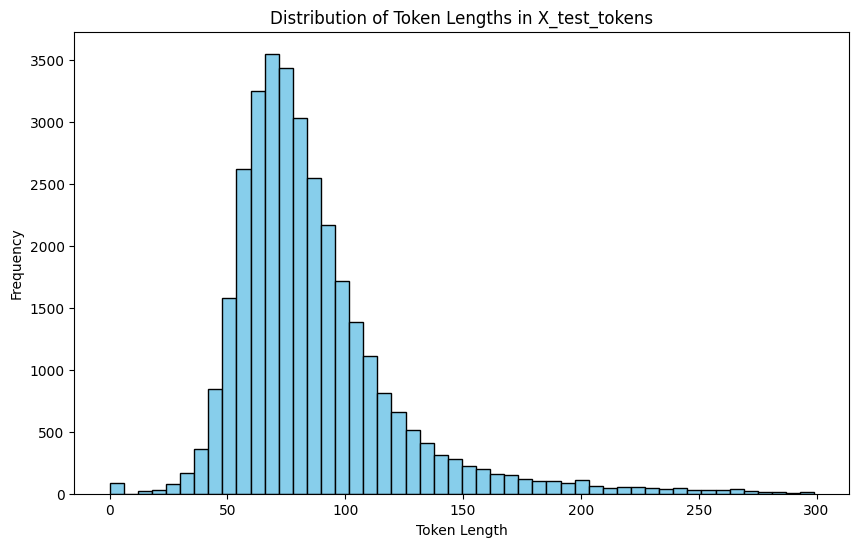

In [33]:

lengths = [len(tokens) for tokens in X_test_tokens_pymorphy2 if len(tokens) < 300]# распределения длины X_test_tokens

plt.figure(figsize=(10, 6))
plt.hist(lengths, bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Token Lengths in X_test_tokens')
plt.xlabel('Token Length')
plt.ylabel('Frequency')
plt.show()

In [37]:
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_lemm)

X_test_tfidf = tfidf_vectorizer.transform(X_test_lemm) 

lr_model = LogisticRegression(max_iter=2000, random_state=43, penalty='l2')# тфидф на лемматизированном
lr_model.fit(X_train_tfidf, y_train)
lr_predictions = lr_model.predict(X_test_tfidf)
accuracy_lr = accuracy_score(y_test, lr_predictions)
print(f"Logistic Regression Accuracy: {accuracy_lr}")
print("Classification Report:\n", classification_report(y_test, lr_predictions))

Logistic Regression Accuracy: 0.920573932881071
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.94      0.92     14037
           1       0.93      0.91      0.92      3962
           2       0.94      0.90      0.92      2347
           3       0.89      0.86      0.87      4291
           4       0.99      0.99      0.99      3142
           5       0.90      0.90      0.90       683
           6       0.88      0.82      0.85       926
           7       0.96      0.94      0.95      1764
           8       0.96      0.91      0.94      2162

    accuracy                           0.92     33314
   macro avg       0.93      0.91      0.92     33314
weighted avg       0.92      0.92      0.92     33314



In [38]:
vec = CountVectorizer()
vec.fit(X_train_lemm)

bow = vec.transform(X_train_lemm)
bow_test = vec.transform(X_test_lemm)
print(bow.shape)

scaler = MaxAbsScaler()
bow = scaler.fit_transform(bow)
bow_test = scaler.transform(bow_test)

clf = LogisticRegression(max_iter=2000, random_state=43, penalty='l2')# bow на лемматизированном тексте

clf.fit(bow, y_train)
pred = clf.predict(bow_test)

print(classification_report(y_test, pred))

(133252, 127991)
              precision    recall  f1-score   support

           0       0.89      0.94      0.91     14037
           1       0.94      0.90      0.92      3962
           2       0.93      0.90      0.92      2347
           3       0.88      0.85      0.87      4291
           4       1.00      0.98      0.99      3142
           5       0.94      0.88      0.91       683
           6       0.86      0.84      0.85       926
           7       0.97      0.93      0.95      1764
           8       0.96      0.91      0.93      2162

    accuracy                           0.92     33314
   macro avg       0.93      0.90      0.92     33314
weighted avg       0.92      0.92      0.92     33314



## Bert Embeddings

In [42]:
model_name = "DeepPavlov/rubert-base-cased"# Загрузка токенизатора и модели BERT
max_seq_length = 128
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.65M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [45]:
max_len = 128

X_train_indices = [tokenizer.convert_tokens_to_ids(tokens) for tokens in X_train_tokens_pymorphy2]# Преобразовать слова в индексы с использованием токенизатора

padded = tf.keras.preprocessing.sequence.pad_sequences(X_train_indices, maxlen=max_len, padding='post', truncating='post', value=0, dtype='int32')# pad_sequences для создания паддингов
padded = np.array(padded)

model.cuda()
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

batch_size = 128
all_hidden_states = []

with torch.no_grad():
    for i in tqdm(range(0, len(padded), batch_size)):
        batch_input_ids = torch.tensor(padded[i:i+batch_size]).cuda()
        batch_attention_mask = torch.tensor(attention_mask[i:i+batch_size]).cuda()

        last_hidden_states = model(batch_input_ids, attention_mask=batch_attention_mask)
        all_hidden_states.append(last_hidden_states[0][:, 0, :].cpu().numpy())

        del batch_input_ids
        del batch_attention_mask
        del last_hidden_states

x_train_emb = np.concatenate(all_hidden_states, axis=0)
x_train_emb[0]

100%|██████████| 1042/1042 [15:51<00:00,  1.09it/s]


array([-9.40100625e-02, -3.00105393e-01,  1.31866717e+00, -6.94031775e-01,
        5.89826703e-01,  1.00460447e-01, -4.26028669e-01,  3.24740171e-01,
       -3.95213604e-01,  9.56752241e-01, -6.75412595e-01, -4.69916642e-01,
        1.71706378e+00,  8.71741414e-01,  6.57711864e-01, -7.39073396e-01,
        3.84123564e-01, -2.26555035e-01,  1.41828728e+00,  4.18499142e-01,
        7.66390085e-01,  6.86905384e-01, -4.38587993e-01,  1.74169451e-01,
       -3.36351663e-01, -5.80657244e-01, -1.69294500e+00,  2.93000966e-01,
       -9.18334424e-01,  3.20645720e-01,  7.59360492e-01,  1.90853745e-01,
        5.11796772e-01,  6.55297875e-01,  3.82410467e-01, -8.42641532e-01,
        9.30646420e-01, -1.60641000e-01,  6.16509557e-01,  9.97721314e-01,
        1.74465090e-01,  1.11778879e+00,  4.14083153e-01,  4.38704818e-01,
       -3.35082889e-01, -5.95647454e-01, -2.02887088e-01,  1.94536999e-01,
       -1.08441746e+00, -4.83906806e-01, -2.51470119e-01, -1.38463065e-01,
       -6.92924619e-01, -

In [46]:
# Тоже самое для теста
X_test_indices = [tokenizer.convert_tokens_to_ids(tokens) for tokens in X_test_tokens_pymorphy2]

padded = tf.keras.preprocessing.sequence.pad_sequences(X_test_indices, maxlen=max_len, padding='post', truncating='post', value=0, dtype='int32')
padded = np.array(padded)

attention_mask = np.where(padded != 0, 1, 0)

all_hidden_states = []

with torch.no_grad():
    for i in tqdm(range(0, len(padded), batch_size)):
        batch_input_ids = torch.tensor(padded[i:i+batch_size]).cuda()
        batch_attention_mask = torch.tensor(attention_mask[i:i+batch_size]).cuda()

        last_hidden_states = model(batch_input_ids, attention_mask=batch_attention_mask)
        all_hidden_states.append(last_hidden_states[0][:, 0, :].cpu().numpy())

        del batch_input_ids
        del batch_attention_mask
        del last_hidden_states

        x_test_emb = np.concatenate(all_hidden_states, axis=0)


100%|██████████| 261/261 [04:01<00:00,  1.08it/s]


In [49]:
scaler = StandardScaler()
x_train_emb_norm = scaler.fit_transform(x_train_emb)# Нормализация эмбеддингов
x_test_emb_norm = scaler.transform(x_test_emb)

In [51]:
x_train_emb_norm.shape

(133252, 768)

In [53]:
clf = LogisticRegression(max_iter=2000, random_state=43, penalty='l2', class_weight='balanced')
clf.fit(x_train_emb_norm, y_train)
pred = clf.predict(x_test_emb_norm)

print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.87      0.54      0.67     14037
           1       0.78      0.84      0.81      3962
           2       0.59      0.86      0.70      2347
           3       0.54      0.75      0.63      4291
           4       0.93      0.95      0.94      3142
           5       0.51      0.89      0.65       683
           6       0.50      0.90      0.65       926
           7       0.66      0.86      0.75      1764
           8       0.70      0.86      0.77      2162

    accuracy                           0.72     33314
   macro avg       0.68      0.83      0.73     33314
weighted avg       0.76      0.72      0.72     33314



## last_hidden_states[:, 0, :]

In [68]:
train_embeddings = []

for text in tqdm(X_train_lemm, desc="Processing texts", position=0, leave=True):

    tokens = tokenizer(text, return_tensors="pt", max_length=max_seq_length, truncation=True)

    with torch.no_grad():# Получение эмбеддингов от модели BERT
        outputs = model(**tokens.to(device)) 
        last_hidden_states = outputs.last_hidden_state.to(device)

    cls_embedding = last_hidden_states[:, 0, :].squeeze().cpu().numpy()
    train_embeddings.append(cls_embedding)

Processing texts: 100%|██████████| 133252/133252 [40:20<00:00, 55.05it/s]


In [70]:
test_embeddings = []
for text in tqdm(X_test_lemm, desc="Processing texts", position=0, leave=True):

    tokens = tokenizer(text, return_tensors="pt", max_length=max_seq_length, truncation=True)
    with torch.no_grad():
        outputs = model(**tokens.to(device))  # Переводим токены на нужное устройство
        last_hidden_states = outputs.last_hidden_state.to(device)

    cls_embedding = last_hidden_states[:, 0, :].squeeze().cpu().numpy()
    test_embeddings.append(cls_embedding)

Processing texts: 100%|██████████| 33314/33314 [10:11<00:00, 54.47it/s]


In [71]:
%%time
clf = LogisticRegression(max_iter=2000, random_state=43, penalty='l2', class_weight='balanced') # Эмбеддинги разные, на этих результат чуть лучше, но все равно плохой
clf.fit(train_embeddings, y_train)
pred = clf.predict(test_embeddings)

print(classification_report(y_test, pred))

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

           0       0.92      0.70      0.80     14037
           1       0.83      0.89      0.86      3962
           2       0.71      0.92      0.80      2347
           3       0.69      0.86      0.76      4291
           4       0.98      0.98      0.98      3142
           5       0.65      0.93      0.76       683
           6       0.62      0.97      0.76       926
           7       0.81      0.93      0.87      1764
           8       0.82      0.91      0.86      2162

    accuracy                           0.82     33314
   macro avg       0.78      0.90      0.83     33314
weighted avg       0.85      0.82      0.82     33314

CPU times: user 53min 4s, sys: 8min 58s, total: 1h 2min 3s
Wall time: 15min 58s


## NN Embedding + LSTM

In [17]:
%%capture
!pip install torch transformers -q
!pip install scikeras -q
!pip install keras-pickle-wrapper
from scikeras.wrappers import KerasClassifier 
import sys
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, GlobalMaxPooling1D, LeakyReLU

from tensorflow.keras.models import Model
from transformers import TFGPT2Model, GPT2Tokenizer, AutoConfig
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, SpatialDropout1D, Dropout
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix
import seaborn as sns
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup

In [19]:
X_train_lemm = np.array(X_train_lemm)
X_test_lemm = np.array(X_test_lemm)

In [ ]:
embedding_dim = 100  # Размер эмбеддинга
batch_size = 8  # 
epochs = 6  # 
learning_rate = 0.001  
optimizer = Adam(learning_rate=learning_rate, use_ema=True,    ema_momentum=0.99,)

from keras.callbacks import ModelCheckpoint
from keras.layers import Embedding, LSTM, Dense, SpatialDropout1D, Dropout

"""model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_sequence_length))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100))
model.add(Dense(9, activation='softmax'))"""
model = Sequential()
model.add(Embedding(input_dim=20_000, output_dim=embedding_dim, input_length=784))#input_dim=max_words,
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, return_sequences=True)) 
model.add(Dropout(0.2))  
model.add(LSTM(100))
model.add(Dense(9, activation='softmax'))
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])


checkpoint = ModelCheckpoint('best_model_weights.h5', 
                             save_best_only=True, 
                             save_weights_only=True, 
                             monitor='val_accuracy', 
                             mode='max', 
                             verbose=1)

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    X_train_lemm, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.2,
    callbacks=[early_stopping, checkpoint])

model.load_weights('best_model_weights.h5')

test_loss, test_accuracy = model.evaluate(X_test_lemm, y_test)# Оценим модель на тестовых данных
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

plot_history(history)

predictions = model.predict(X_test_lemm)
predicted_classes = np.argmax(predictions, axis=1)

conf_matrix = confusion_matrix(y_test, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(9), yticklabels=range(9))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_test, predicted_classes))

## Bert Finetune (на маленьком датасете хуже, на большом - долго)

In [ ]:
tokenizer = BertTokenizer.from_pretrained('DeepPavlov/rubert-base-cased') # 'rubert_base_cased_sentence/'

class NewsDataset(Dataset):
    def __init__(self, texts, labels, max_len=512):
        self.texts = texts
        self.labels = labels
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = int(self.labels[idx])

        encoding = tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

train_dataset = NewsDataset(texts=train['text'].values, labels=train['category'].values)
test_dataset = NewsDataset(texts=valid['text'].values, labels=valid['category'].values)


In [ ]:
model = BertForSequenceClassification.from_pretrained('DeepPavlov/rubert-base-cased', num_labels=9) # 'rubert_base_cased_sentence/'
optimizer = AdamW(model.parameters(), lr=1e-5)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_dataset))

for param in model.bert.parameters():
    param.requires_grad = False

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']

You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
num_epochs = 4
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for batch in tqdm_bar(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}'):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()
        scheduler.step()

    average_loss = total_loss / len(train_loader)
    print(f'Training Loss: {average_loss}')

    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm_bar(test_loader, desc=f'Epoch {epoch + 1}/{num_epochs} - Evaluating'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    print(f'Validation Accuracy: {accuracy}')

Epoch 1/4: 100%|██████████| 559/559 [22:16<00:00,  2.39s/it]


Training Loss: 2.1544942378144785


Epoch 1/4 - Evaluating: 100%|██████████| 140/140 [05:22<00:00,  2.30s/it]


Validation Accuracy: 0.229770565193061


Epoch 2/4: 100%|██████████| 559/559 [22:17<00:00,  2.39s/it]


Training Loss: 2.10852472172227


Epoch 2/4 - Evaluating: 100%|██████████| 140/140 [05:19<00:00,  2.28s/it]


Validation Accuracy: 0.36217123670956913


Epoch 3/4:  69%|██████▊   | 384/559 [15:22<07:00,  2.40s/it]


KeyboardInterrupt: ignored